## Convolución e imágenes  
Voy a ver de implementar la creación y reconstrucción de imágenes simplemente realizando la convolución, primero como filtro (con kernels que acentúen los bordes y eso) y luego con la detección y reconstrucción de imágenes tipo coded aperture.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import convolve

In [3]:
imagen = np.array([[1, 2, 0],
              [5, 3, 0],
              [0, 0, 0],
              [9, 3, 0]])

kernel = np.array([[1,1],[1,1]])
convolucion = convolve(imagen, kernel, mode='constant', cval=0.0)
print(convolucion)

[[11  5  0]
 [ 8  3  0]
 [12  3  0]
 [12  3  0]]


Bueno ahi lo que tenemos es que centra el (0,0) del kernel con el (0,0) de la imagen (esquina superior izquierda siempre). Si no le alcanza (a la derecha le va a pasar), rellena con 0. Voy a cambiar cval a 1 a ver qué pasa

In [4]:
imagen = np.array([[1, 2, 0],
              [5, 3, 0],
              [0, 0, 0],
              [9, 3, 0]])

kernel = np.array([[1,1],[1,1]])
convolucion = convolve(imagen, kernel, mode='constant', cval=1.0)
print(convolucion)

[[11  5  2]
 [ 8  3  2]
 [12  3  2]
 [14  5  3]]


Pasa lo mismo que antes pero ahora rellena con unos! Voy a cambiar el origen de las coordenadas. De la documentación:
origin int, optional
Controls the origin of the input signal, which is where the filter is centered to produce the first element of the output. Positive values shift the filter to the right, and negative values shift the filter to the left. Default is 0.

In [5]:
imagen = np.array([[1, 2, 0],
              [5, 3, 0],
              [0, 0, 0],
              [9, 3, 0]])

kernel = np.array([[1,1],[1,1]])
convolucion = convolve(imagen, kernel, mode='constant', cval=0.0, origin = -1)
print(convolucion)

[[ 1  3  2]
 [ 6 11  5]
 [ 5  8  3]
 [ 9 12  3]]


Acá es como si lo centrara el elemento 1,1 del kernel con el 0,0 de la imagen (y rellena todo con ceros). Después se va moviendo. Voy a hacer un kernel de 3x3 a ver que onda, que es el que se usa más. El original ejemplo

In [6]:
import numpy as np
a = np.array([[1, 2, 3, 4],
              [5, 6, 7, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])
k = np.array([[1,0,0],
              [1,1,0],
              [0,0,1]])
from scipy import ndimage
ndimage.convolve(a, k, mode='constant', cval=0.0)
print(k.shape)
print(a.shape)

(3, 3)
(4, 4)


Bueno entendí!! Lo que hace arriba es reflejar el kernel vertical y horizontalmente, centrar el kernel sobre el primer elemento (superpone el elemento (1,1) del kernel con el elemento a calcular) y rellena todo con el cval que le pongas. 

### Pruebo hacer una convolución con alguna máscara entonces, alguna simple. 

Text(0.5, 1.0, 'Mask')

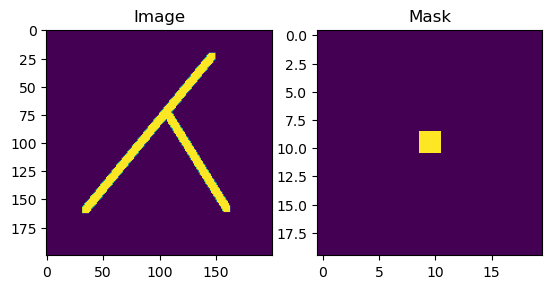

In [3]:
from PIL import Image

#imagen que quiero ver
image = Image.open('exp_pics/lambda_pattern.png')
imagen_array = np.array(image)
plt.subplot(1,2,1)
c = plt.imshow(imagen_array[:,:,3]*0.5) #solo tiene algo la última matriz las otras son 0
plt.title('Image')
#plt.colorbar(c)

#la voy a convolucionar con un pinhole común 
def generate_pinhole_mask(height, length, hole_radius):
    """Generates a mask with a pinhole shape"""
    mask = np.zeros((height, length))
    # Define the lambda shape
    mask[
        int(height * 0.5) - hole_radius : int(height * 0.5) + hole_radius,
        int(length * 0.5) - hole_radius : int(length * 0.5) + hole_radius,
    ] = 1
    return mask

pinhole = generate_pinhole_mask(20,20,1)
plt.subplot(1,2,2)
plt.imshow(pinhole)
plt.title('Mask')


In [60]:
print(pinhole.shape)
print(imagen_array.shape)

(10, 10)
(200, 200, 4)


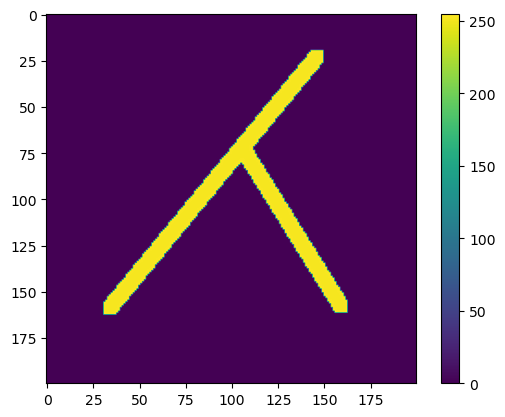

In [8]:
convolucion = convolve(imagen_array[:,:,3], pinhole, mode = 'constant', cval = 0.0)
c = plt.imshow(convolucion)
plt.colorbar(c)

### Le agrego un segundo pinhole 

Text(0.5, 1.0, 'Mask')

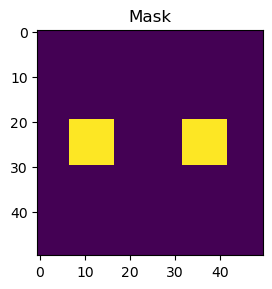

In [40]:
def generate_double_pinhole_mask(height, length, hole_radius):
    """Generates a mask with a pinhole shape"""
    mask = np.zeros((height, length))
    # Define the lambda shape
    mask[
        int(height * 0.5) - hole_radius : int(height * 0.5) + hole_radius,
        int(length * 0.25) - hole_radius : int(length * 0.25) + hole_radius,
    ] = 1
    mask[
        int(height * 0.5) - hole_radius : int(height * 0.5) + hole_radius,
        int(length * 0.75) - hole_radius : int(length * 0.75) + hole_radius,
    ] = 1
    return mask

double_pinhole = generate_double_pinhole_mask(50,50,5)
plt.subplot(1,2,2)
plt.imshow(double_pinhole)
plt.title('Mask')

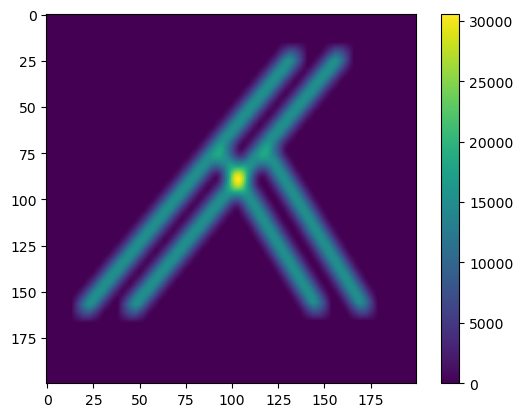

In [10]:
convolucion = convolve(imagen_array[:,:,3]*0.75, double_pinhole, mode = 'constant', cval = 0.0)
c = plt.imshow(convolucion)
plt.colorbar(c)

Bueno, joya. Se ve que se repite el patron, que estoy empezando a ver las figuras superpuestas, una por cada pinhole. 
Vamos con un patron de pinholes mas complejo y una busqueda de reconstruccion

0.023


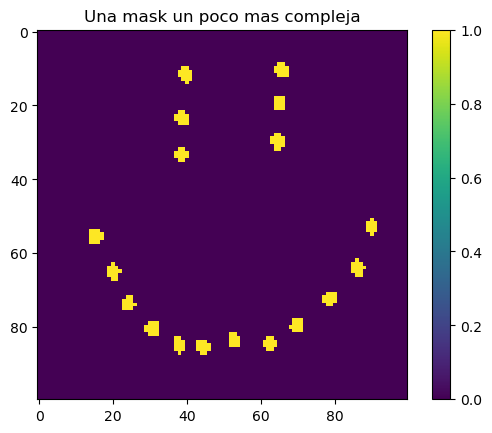

In [34]:
face_pinhole = Image.open('exp_pics/face_pinhole_processed.png')
face_pinhole_array = np.array(face_pinhole)
binary_image_face_mask = (face_pinhole_array > 100).astype(np.uint8) #aca la binarizo
c = plt.imshow(binary_image_face_mask)
plt.colorbar(c)
plt.title('Una mask un poco mas compleja')
transparency = np.sum(np.sum(binary_image_face_mask == 1))/(len(binary_image_face_mask)**2)
print(transparency)

Text(0.5, 1.0, 'Convolution')

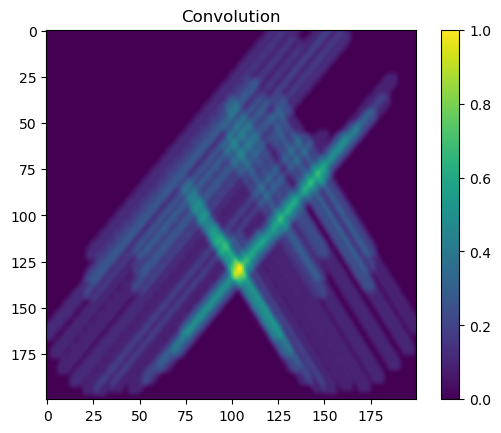

In [35]:
convolucion = convolve(imagen_array[:,:,3]*0.55, binary_image_face_mask, mode = 'constant', cval = 0.0)
c = plt.imshow(convolucion/np.max(convolucion))
plt.colorbar(c)
plt.title('Convolution')

Ok, no se ve nada, vamos a intentar deconvolucionar

1.0


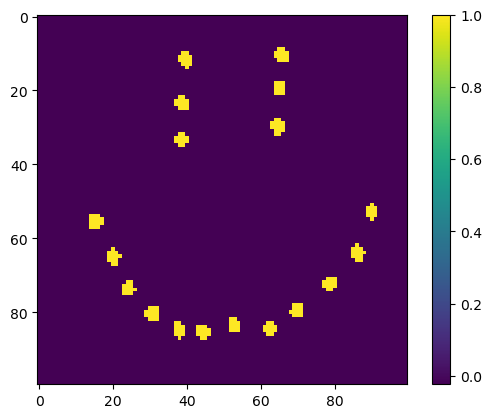

In [37]:
def decoding_mask(coding_mask):
    decoding_matrix = coding_mask.copy()
    transparency = np.sum(np.sum(decoding_matrix == 1))/(len(decoding_matrix)**2)
    return [[transparency/(transparency-1) if element == 0 else element for element in row] for row in decoding_matrix]

decoding_face_mask = decoding_mask(binary_image_face_mask)
print(np.max(decoding_face_mask))
c = plt.imshow(decoding_face_mask)
plt.colorbar(c)

Text(0.5, 1.0, 'Reconstructed')

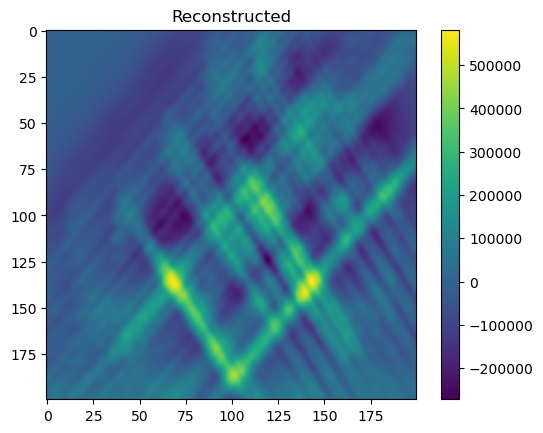

In [38]:
reconstructed_image = convolve(convolucion, decoding_face_mask, mode = 'constant', cval = 0.0)
c = plt.imshow(reconstructed_image)
plt.colorbar(c)
plt.title('Reconstructed')

No se ve una mierda :) Tan mala es la reconstrucción? Pruebo con los el double pinhole

1.0


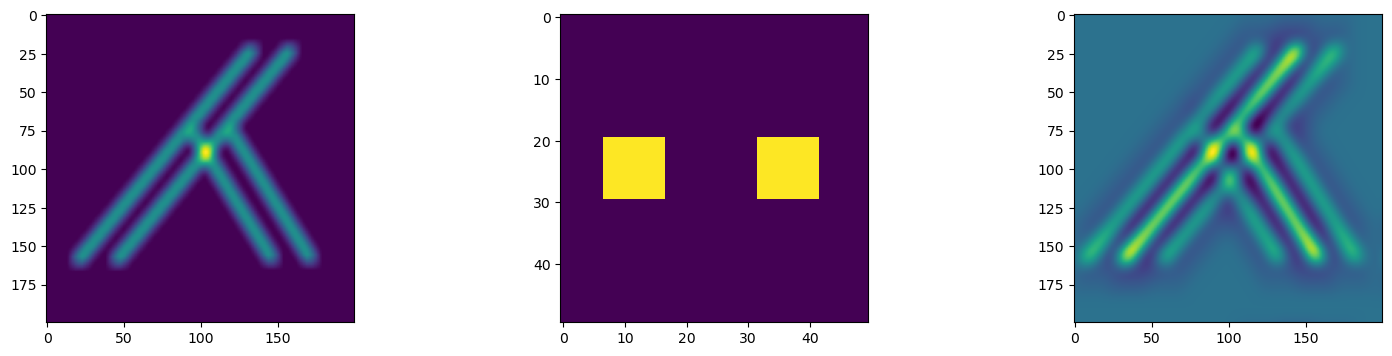

In [41]:
convolucion_double_pinhole = convolve(imagen_array[:,:,3]*0.75, double_pinhole, mode = 'wrap')
f, ax = plt.subplots(ncols=3, figsize=(18,4))
f.subplots_adjust(wspace=0.4)
a = ax[0].imshow(convolucion_double_pinhole)
#lt.colorbar(a)


decoding_double_pinhole = decoding_mask(double_pinhole)
print(np.max(decoding_double_pinhole))
b = ax[1].imshow(decoding_double_pinhole)


reconstructed_image = convolve(convolucion_double_pinhole, decoding_double_pinhole, mode = 'wrap')
c = ax[2].imshow(reconstructed_image)



### MURA - librería codedapertures

Modified Uniformly Redundant Array
----------------------------------
rank:   3
L:      29
tile:   (1, 1)
width:  29
height: 29


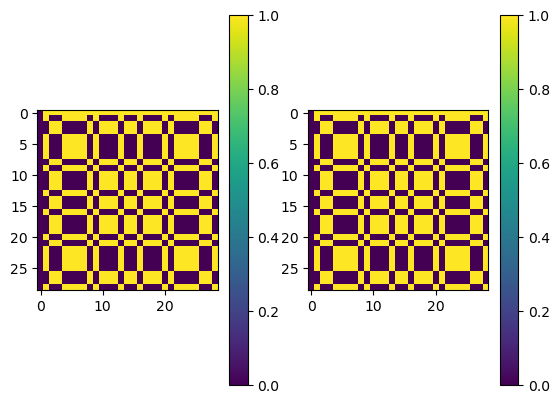

In [4]:
import codedapertures as ca

mura = ca.mura(rank=3, tile=None, center=True)
plt.subplot(1,2,1)
c = plt.imshow(mura.aperture)
plt.colorbar(c)

mura.gen_decoder()
plt.subplot(1,2,2)
d = plt.imshow(mura.decoder)
plt.colorbar(d)

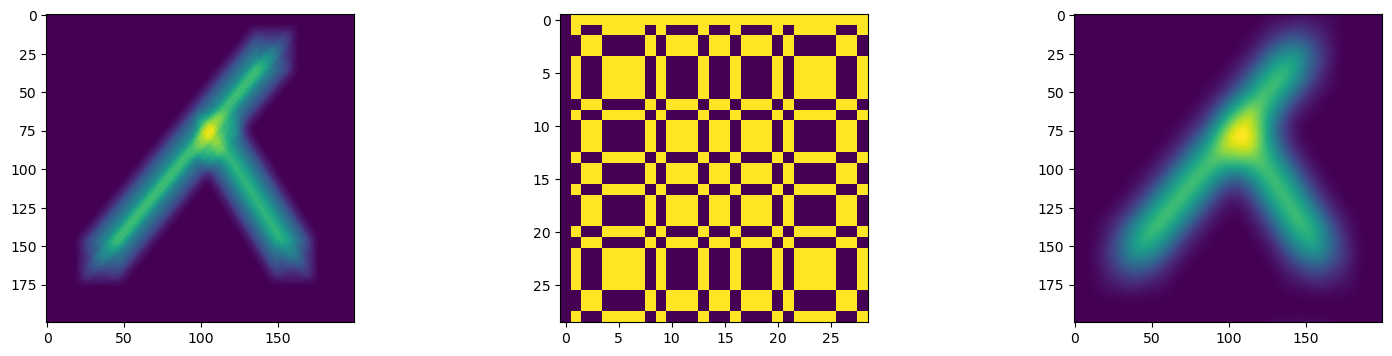

In [5]:
convolucion_mura = convolve(imagen_array[:,:,3]*0.25, mura.aperture, mode = 'wrap')
f, ax = plt.subplots(ncols=3, figsize=(18,4))
f.subplots_adjust(wspace=0.4)
a = ax[0].imshow(convolucion_mura)

b = ax[1].imshow(mura.aperture)

reconstructed_image = convolve(convolucion_mura, mura.decoder, mode = 'wrap')
c = ax[2].imshow(reconstructed_image)

Voy con una imagen un poco más compleja. Qué pasa con una foto incluso?

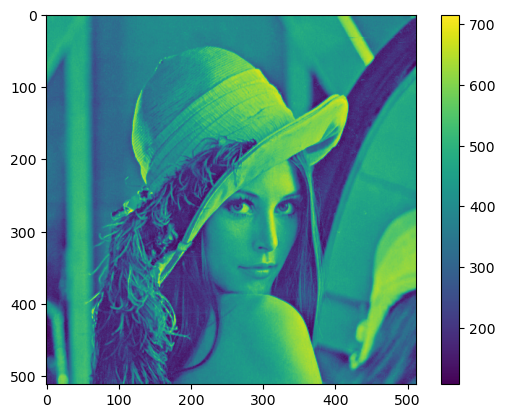

In [217]:
lenna = Image.open('exp_pics/lenna.jpg')
lenna_greyscale = np.sum(np.array(lenna),2)
lenna_greyscale.shape
c = plt.imshow(lenna_greyscale)
plt.colorbar(c)

Modified Uniformly Redundant Array
----------------------------------
rank:   15
L:      149
tile:   (1, 1)
width:  149
height: 149


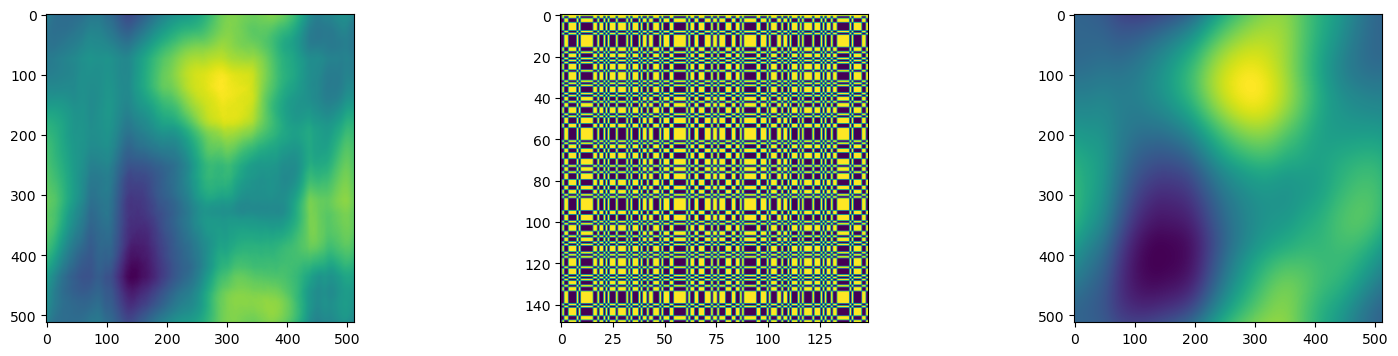

In [227]:
mura = ca.mura(rank=15, tile=None, center=True)
mura.gen_decoder()

convolucion_mura_lenna = convolve(lenna_greyscale, mura.aperture, mode = 'wrap')
f, ax = plt.subplots(ncols=3, figsize=(18,4))
f.subplots_adjust(wspace=0.4)
a = ax[0].imshow(convolucion_mura_lenna)

b = ax[1].imshow(mura.aperture)

reconstructed_image = convolve(convolucion_mura_lenna, mura.decoder, mode = 'wrap')
c = ax[2].imshow(reconstructed_image)

Lo que me pasa con esto es que me da la sensación de que la imagen reconstruida se ve peor que la original. Tiene sentido porque el mura coder y el decorder son exactamente lo mismo entonces la verdad es que estoy haciendo dos veces el proceso de detección. No le confío a este algoritmo vamos a ver qué pasa si me armo mi propia máscara Mura y decodificador Mura. 

## Busco armar mi propio MURA Decoder

For each MURA mask pattern an inverse decoding pattern 𝐺 can be determined [17]. Correlation
of the decoding and encoding pattern results in a 𝛿-distribution and can be regarded as an inverse
ﬁlter [10]. The decoding pattern 𝐺 in relation to the encoding pattern 𝐻 equals

In practical terms that means all 0 change to -1 and all 1 stay 1 except for the central pixel if a 2×2
mosaicked mask is chosen [15]. Convolving the given detector image with the decoding pattern
and central cropping yields the reconstructed object image.

In [7]:
def decoding_mura(coding_mask):
    decoding_mask = coding_mask.copy()

    k = int(- coding_mask.shape[0]/2)
    l = int(- coding_mask.shape[1]/2)
    print(k,l)

    for i in range(coding_mask.shape[0]):
        for j in range(coding_mask.shape[1]):
            if k + i + l + j == 0:
                decoding_mask[i,j] = 1
            elif coding_mask[i,j] == 0:
                decoding_mask[i,j] = -1
    return decoding_mask

Modified Uniformly Redundant Array
----------------------------------
rank:   13
L:      113
tile:   (2, 2)
width:  226
height: 226
-113 -113


MemoryError: 

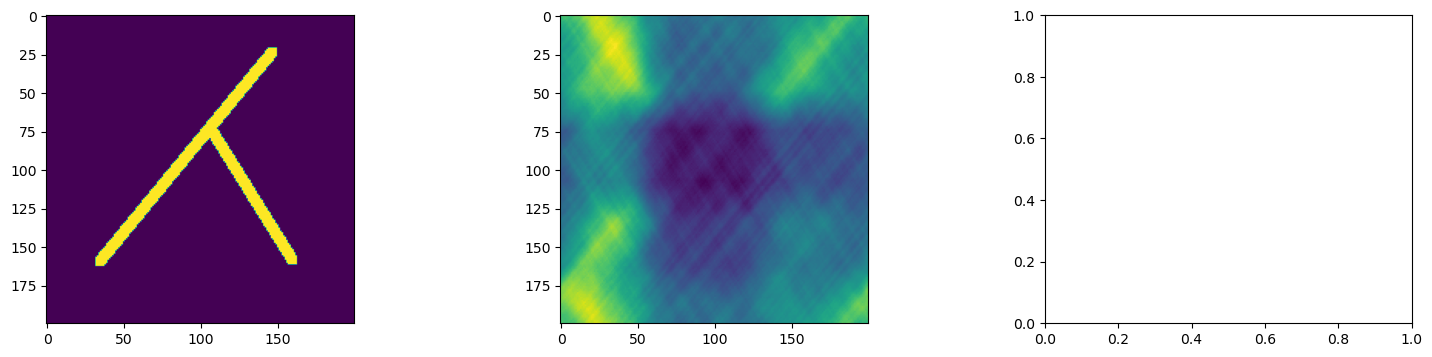

In [10]:

mura = ca.mura(rank=13, tile=None, center=True)

convolucion_mura_lambda = convolve(imagen_array[:,:,3]*0.55, mura.aperture, mode = 'wrap')
f, ax = plt.subplots(ncols=3, figsize=(18,4))
f.subplots_adjust(wspace=0.4)

ax[0].imshow(imagen_array[:,:,3]*0.25)
ax[1].imshow(convolucion_mura_lambda)

decoding_mask = decoding_mura(mura.aperture)
reconstructed_image = convolve(convolucion_mura_lambda, decoding_mask, mode = 'wrap')

ax[2].imshow(reconstructed_image)

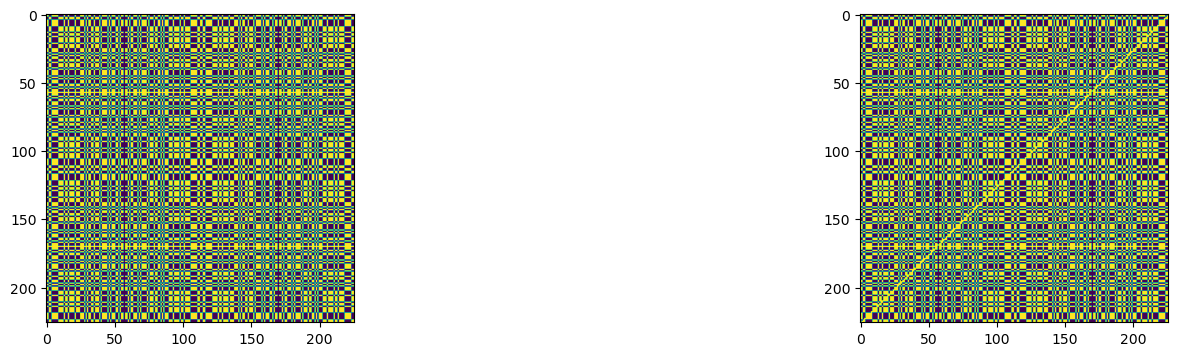

In [11]:
f, ax = plt.subplots(ncols=2, figsize=(18,4))
f.subplots_adjust(wspace=0.4)
ax[0].imshow(mura.aperture)
ax[1].imshow(decoding_mask)

In [32]:
del(convolucion)